## Application gpt_annotate on manual labels - determination of relevance
Notes on LLM annotation following Nihit 7/5:
- Add inclusion of context in your codebook "you can take the previous and next two sentences into account as context.-> could be removed - currently not included
- Evaluate if this truely makes a difference

- Separate labelling for relevance; evaluate performance
- 2 experiments
    - only annotating for principles on sentences deemed relevant in previous iteration
    - combing two tasks - more ellaborate codebook.

Take costs into account. Not a bad thing to use what already exists

THIS NOTEBOOK: focus on determination of relevance. Full annotation tasks VERY long.

Conclusion on initial performance of relevance determination: poor.

### Set up dependencies

In [1]:
!pip install openai


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\App\Python\python.exe -m pip install --upgrade pip


In [2]:
!pip install tiktoken


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: C:\App\Python\python.exe -m pip install --upgrade pip


In [1]:
import openai
import pandas as pd
import math
import time
import numpy as np
import tiktoken

import matplotlib.pyplot as plt

In [2]:
#### Import main package: gpt_annotate.py
# Make sure that the .py file is in the same directory as the .ipynb file, or you provide the correct relative or absolute path to the .py file.
import gpt_annotate

In [3]:
# don't type the key in this file! 
# create gpt_api.txt, put the key in that, and save
with open('gpt_api_key.txt', 'r') as f:
    key = f.read().strip()

### Load in text_to_annotate and codebook

In [5]:
# Load text to annotate
text_to_annotate_full = pd.read_csv("data/HLS_train_dummies.csv")

# For testing purposes, only select japan speech
#select_cop = text_to_annotate_full[text_to_annotate_full['id']=='COP19_japan']

#text_to_annotate = text_to_annotate_full[["Text", "principle_0", "principle_1", "principle_2", "principle_3", "principle_4", "principle_5", "principle_6"]]

text_to_annotate = text_to_annotate_full[["Text", "relevance_0", "relevance_1", "relevance_2"]]

text_to_annotate

,Text,relevance_0,relevance_1,relevance_2
0,"Thank you, Mr. President .",1,0,0
1,"On beha lf of the government of Japan , I wou...",1,0,0
2,I would also like to expr ess my d eepest con...,1,0,0
3,Mr. President: A fair and effective framewor...,0,0,1
4,"In this regard, Japan firmly supports the est...",0,1,0
...,...,...,...,...
1207,New Zealand is proud to suppor t several impo...,1,0,0
1208,"I am joined by New Zealand’s largest business,...",1,0,0
1209,The commitment o f New Zealanders from across ...,1,0,0
1210,Thank you Mr President.,1,0,0


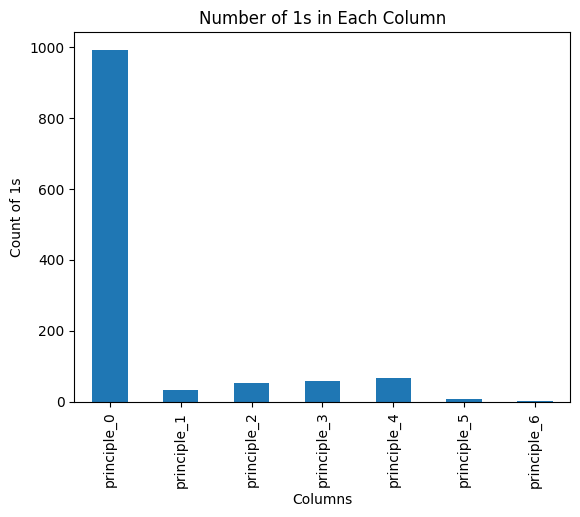

In [11]:
# Make a bar plot of the principle counts in each column
counts = text_to_annotate[["principle_0", "principle_1", "principle_2", "principle_3", "principle_4", "principle_5", "principle_6"]].sum()

# Step 4: Plot the counts using a bar plot
counts.plot(kind='bar')

# Adding titles and labels
plt.title('Number of 1s in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of 1s')

# Display the plot
plt.show()

In [12]:
# Final check for binary columns
invalid_columns = [col for col in text_to_annotate.columns if not all(text_to_annotate[col].isin([0, 1]))]

if len(invalid_columns) == 0:
    print("All columns contain only 0 or 1.")
else:
    print("Columns with elements not being 0 or 1:")
    for col in invalid_columns:
        print(col)

Columns with elements not being 0 or 1:
Text


In [6]:
# Load codebook
with open('Codebook/codebook_V7_relevance', 'r', encoding='utf-8') as file:
    codebook = file.read()

codebook

'"You are tasked to annotate sentences from speeches presented at the High Level Segment at UNFCCC Conference of the Parties.\nAssign binary labels (0 or 1) for these 3 categories with category names: \'relevance_0\', \'relevance_1\', \'relevance_2\'. Follow the provided definitions of the categories during labelling process.\nALWAYS ensure 1 of 3 categories is labelled as 1, the other two must be 0.\n\nLabelling steps for each sentence:\n1. Evaluate the sentence. Take the 2 previous and 2 next sentences in you annotate into account as context to your evaluation.\n2. Determine the BINARY label (0 or 1) of all 3 CATEGORIES (\'relevance_0\', \'relevance_1\', \'relevance_2\') based on the following DEFINITIONS:\n    a.\trelevance_0: Descriptive or Factual Statements\n        Definition: A sentence that presents a descriptive or factual statement, including descriptions of policies already implemented or expressions of gratitude, condolences, formalities, or rhetorical questions.\n    b.\t

# Annotate train data - manually annotated COP19-COP28 - total 41 speeches

codebook: codebook_V4_relevance - determination of relevance

In [7]:
# Prepare the data for annotation
# Preparation is done with GPT-3.5-turbo - can be altered hardcoded
text_to_annotate = gpt_annotate.prepare_data(text_to_annotate, codebook, key, prep_codebook=True)


Categories to annotate:
1) relevance_0
2) relevance_1
3) relevance_2


Data is ready to be annotated using gpt_annotate()!

Glimpse of your data:
Shape of data:  (1212, 6)
   unique_id                                               text  relevance_0  \
0          0                         Thank you, Mr. President .            1   
1          1   On beha lf of the government of Japan , I wou...            1   
2          2   I would also like to expr ess my d eepest con...            1   
3          3   Mr. President:  A fair and effective framewor...            0   
4          4   In this regard, Japan firmly supports the est...            0   

   relevance_1  relevance_2                                          llm_query  
0            0            0                    0  Thank you, Mr. President .\n  
1            0            0  1  On beha lf of the government of Japan , I w...  
2            0            0  2  I would also like to expr ess my d eepest c...  
3            0        

In [10]:
# Annotate the data (returns 4 outputs)
gpt_out_all, gpt_out_final, performance, incorrect =  gpt_annotate.gpt_annotate(text_to_annotate, codebook, key, num_iterations = 5, model = "gpt-3.5-turbo", temperature = 0.6, batch_size = 20, human_labels = True,  data_prep_warning = False, time_cost_warning = True)

You are about to annotate 1212 text samples and the number of iterations is set to 5
Estimated cost range in US Dollars: 0.82 - 1.0
Estimated minutes to run gpt_annotate(): 52.98 - 98.4
Please note that these are rough estimates.

iteration:  1 completed
iteration:  2 completed
iteration:  3 completed
iteration:  4 completed
iteration:  5 completed


In [11]:
# Results updated gpt_annotate to alter all non binary elements - hopefully problem fixed. - let op, output is not specified!
performance

,Category,Accuracy,Precision,Recall,F1
0,relevance_0,0.508861,0.818493,0.311198,0.450943
1,relevance_1,0.613502,0.237500,0.553398,0.332362
2,relevance_2,0.699578,0.265372,0.388626,0.315385


In [21]:
performance

,Category,Accuracy,Precision,Recall,F1
0,principle_0,0.215035,1.000000,0.047720,0.091093
1,principle_1,0.972902,0.000000,0.000000,0.000000
2,principle_2,0.940559,0.000000,0.000000,0.000000
3,principle_3,0.930070,0.166667,0.107143,0.130435
4,principle_4,0.926353,0.205128,0.133333,0.161616
5,principle_5,0.991259,0.000000,0.000000,0.000000
6,principle_6,0.969406,0.027778,1.000000,0.054054


In [14]:
incorrect

,unique_id,text,relevance_0_true,relevance_1_true,relevance_2_true,relevance_0_pred,relevance_1_pred,relevance_2_pred,consistency_relevance_0,consistency_relevance_1,...,correct_2,tp_2,tn_2,fp_2,fn_2,correct_3,tp_3,tn_3,fp_3,fn_3
0,1,"On beha lf of the government of Japan , I wou...",1,0,0,1.0,0.0,0.0,0.714286,1.000000,...,1,0,1,0,0,1,0,1,0,0
1,2,I would also like to expr ess my d eepest con...,1,0,0,0.0,0.0,1.0,1.000000,1.000000,...,1,0,1,0,0,0,0,0,1,0
2,3,Mr. President: A fair and effective framewor...,0,0,1,0.0,1.0,0.0,1.000000,1.000000,...,0,0,0,1,0,0,0,0,0,1
3,4,"In this regard, Japan firmly supports the est...",0,1,0,1.0,0.0,0.0,1.000000,1.000000,...,0,0,0,0,1,1,0,1,0,0
4,5,Such a framework must be based on “nationally ...,0,0,1,0.0,1.0,0.0,1.000000,0.714286,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,1205,"We need a course correction, and working toge...",0,0,1,0.0,1.0,0.0,1.000000,0.714286,...,0,0,0,1,0,0,0,0,0,1
1200,1206,Together we can: • Collaborate and partner to ...,1,0,0,0.0,1.0,0.0,1.000000,0.857143,...,0,0,0,1,0,1,0,1,0,0
1201,1207,New Zealand is proud to suppor t several impo...,1,0,0,0.0,1.0,0.0,0.714286,0.714286,...,0,0,0,1,0,1,0,1,0,0
1202,1208,"I am joined by New Zealand’s largest business,...",1,0,0,0.0,1.0,0.0,0.857143,0.714286,...,0,0,0,1,0,1,0,1,0,0


## Results - V6 relevance - T1
Temperature: 0.6
Batch Size: 20
Model: gpt-3.5-turbo
iterations: 5

Observation: seems like instructions are not followed. Update codebook to specify EXTREMELY well that instructions should be followed.